# WGAN 

Example of Wasserstein Generative Adversarial Network (WGAN) with TensorFlow (TF) 2. This example builds a WGAN from scratch, with custom layers and training.

Sources:

*   [Github - WGAN](https://github.com/martinarjovsky/WassersteinGAN)
*   [Ahlad Kumar - Deep Learning 37](https://youtu.be/XK0TJPeZVbs)
*   [Erik Linder-Norén - Keras GAN](https://github.com/eriklindernoren/Keras-GAN)


`Author: Rodrigo Vimieiro`

`Date: Aug, 2020`



<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/LAVI-USP/Machine-Learning/blob/master/Deep%20Learning/GANs/CNN_WGAN_fashion_mnist.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/LAVI-USP/Machine-Learning/blob/master/Deep%20Learning/GANs/CNN_WGAN_fashion_mnist.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


In [ ]:
import tensorflow as tf
import functools
import matplotlib.pyplot as plt
import sys
import numpy as np

## Define MNIST help functions:

In [ ]:
class MNIST_Helper():
    
  def download(self):

    # Loads the MNIST dataset.
    (self.x_train, self.y_train) ,(self.x_test, self.y_test) =  tf.keras.datasets.fashion_mnist.load_data()

    self.x_train = np.concatenate((self.x_train, self.x_test), axis=0)
    self.y_train = np.concatenate((self.y_train, self.y_test), axis=0)

    self.train_dataset_shape = self.x_train.shape


  def print_information(self):

    # Print informations about the MNIST dataset.
    print("There is %d training samples, containing images with shape of: %dx%d and %d channel" 
          % (self.train_dataset_shape[0],self.train_dataset_shape[1],self.train_dataset_shape[2],self.train_dataset_shape[3]))
    print("Train variable shape:", end='')
    print(self.train_dataset_shape)

  def pre_process(self):

    # Reshape to have 1 channel (last dimension) and normalize
    self.x_train = np.expand_dims(self.x_train, axis=-1).astype(np.float32)

    # Normalize data
    ## https://stats.stackexchange.com/questions/185853/why-do-we-need-to-normalize-the-images-before-we-put-them-into-cnn
    self.x_train = (self.x_train - 127.5)/127.5

    self.train_dataset_shape = self.x_train.shape
  
  def create_dataset_iterable(self):

    # Create database objects
    self.train_dataset = tf.data.Dataset.from_tensor_slices((self.x_train, self.y_train))
      
  def shuffle_dataset(self, dataset_size):
    
    return self.train_dataset.shuffle(dataset_size)

### Defining the GAN model:

In [ ]:
class GEN(tf.keras.models.Model):

  def __init__(self, shape):

    super(GEN, self).__init__()

    self.img_shape = shape
    self.noise_in_dim = (100,)
    self.n_filters = 128

    self.generator = self.build_generator()

  def build_generator(self):

    Conv2DT = functools.partial(tf.keras.layers.Conv2DTranspose, padding='same', activation=None, strides=2, kernel_size=5, use_bias=False)
    Dense = tf.keras.layers.Dense
    BatchNormalization = tf.keras.layers.BatchNormalization
    ReLU =  tf.keras.layers.LeakyReLU
    Reshape = tf.keras.layers.Reshape

    model = tf.keras.Sequential([

      Dense(units=(7*7*256), use_bias=False, input_shape=self.noise_in_dim),
      BatchNormalization(),
      ReLU(),
      Reshape((7, 7, 256)),
                            
      Conv2DT(filters=self.n_filters, strides=1),
      BatchNormalization(),
      ReLU(),

      Conv2DT(filters=int(self.n_filters/2)),
      BatchNormalization(),
      ReLU(),

      Conv2DT(filters=1, activation='tanh'),

    ])
      
    return model

  def call(self, x):

    return self.generator(x)


class DIS(tf.keras.models.Model):

  def __init__(self, shape):

    super(DIS, self).__init__()

    self.img_shape = shape
    self.n_filters = 16

    self.discriminator = self.build_discriminator()

  def build_discriminator(self):
    
    Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation=None, strides=2, kernel_size=5, use_bias=True)
    LeakyReLU = tf.keras.layers.LeakyReLU
    BatchNormalization = tf.keras.layers.BatchNormalization
    Flatten = tf.keras.layers.Flatten
    Dense = tf.keras.layers.Dense

    model = tf.keras.Sequential([

      Conv2D(filters=1*self.n_filters, input_shape=self.img_shape),  
      BatchNormalization(),                         
      LeakyReLU(),

      Conv2D(filters=2*self.n_filters),
      BatchNormalization(),
      LeakyReLU(),

      Conv2D(filters=4*self.n_filters),
      BatchNormalization(),
      LeakyReLU(),

      Flatten(),
      Dense(units=1, activation=None, use_bias=True)

    ])

    return model

  def call(self, x):

    return self.discriminator(x)

class GAN():

  def __init__(self, shape):

    self.img_shape = shape

    self.generator = GEN(self.img_shape)
    self.discriminator = DIS(self.img_shape)

### Defining the optimizer:

In [ ]:
def create_optimizer(learning_rate):

  return tf.keras.optimizers.RMSprop(learning_rate) # define our optimizer

### Defining the trainning step:

In [ ]:
@tf.function
def dis_train_step(gan, z_noise, x_input, optimizer):

  with tf.GradientTape() as tape:

    # Generate a batch of new images
    gen_imgs = gan.generator(z_noise)       # G(z)

    gen_pred  = gan.discriminator(gen_imgs) # D(G(z))
    real_pred = gan.discriminator(x_input)  # D(x)

    # Calc the Wasserstein loss
    # The minus sign is because we want to maximize
    loss = -(tf.math.reduce_mean(real_pred) - tf.math.reduce_mean(gen_pred))

    ### Backpropagation ###
    # Get the gradients
    grads = tape.gradient(loss, gan.discriminator.trainable_variables)

    # Update the weights
    optimizer.apply_gradients(zip(grads, gan.discriminator.trainable_variables))

  return loss

@tf.function
def gen_train_step(gan, z_noise, optimizer):

  with tf.GradientTape() as tape:

    # Generate a batch of new images
    gen_imgs = gan.generator(z_noise)       # G(z)
    gen_pred  = gan.discriminator(gen_imgs) # D(G(z))

    # Calc the Wasserstein loss
    # The minus sign is due to the formula
    loss = -tf.math.reduce_mean(gen_pred)

    ### Backpropagation ###
    # Get the gradients
    grads = tape.gradient(loss, gan.generator.trainable_variables)

    # Update the weights
    optimizer.apply_gradients(zip(grads, gan.generator.trainable_variables))

  return loss


### Defining the trainning loop:


In [ ]:
def sample_images(gan, epoch, show=False):

  r, c = 5, 5
  # Sample noise as generator input
  z_noise = tf.random.normal(shape=(r*c,100), mean=0.0, stddev=1.0)
  gen_imgs = gan.generator(z_noise)       # G(z)

  # Rescale images 0 - 1
  gen_imgs = 0.5 * gen_imgs + 0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
      for j in range(c):
          axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
          axs[i,j].axis('off')
          cnt += 1
  if show:
    fig.show()
  else:
    fig.savefig("mnist_%d.png" % epoch)
    plt.close()

In [ ]:
def train_model(gan, num_epochs, batch_size, learning_rate, sample_interval):

  dOptimizer = create_optimizer(learning_rate)
  gOptimizer = create_optimizer(learning_rate)

  # Create a Checkpoint
  ckpt = tf.train.Checkpoint(step=tf.Variable(1), 
                             optimizerD=dOptimizer, 
                             optimizerG=gOptimizer, 
                             modelD=gan.discriminator,
                             modelG=gan.generator)

  # Create a Checkpoint Manager
  manager = tf.train.CheckpointManager(ckpt, './tf_ckpts', max_to_keep=3)

  # Restore from last checkpoint, if exist
  ckpt.restore(manager.latest_checkpoint)
  if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
  else:
    print("Initializing from scratch.")

  gen_loss_history = []
  dis_loss_history = []

  metrics_names = ['gen_loss','dis_loss'] 
  
  # Loop on each epoch
  for epoch in range(num_epochs):

    print("\nepoch {}/{}".format(epoch+1,num_epochs))

    progBar = tf.keras.utils.Progbar(MNIST.train_dataset_shape[0], stateful_metrics=metrics_names, interval=0.5)

    MNIST.shuffle_dataset(MNIST.train_dataset_shape[0])

    # Loop on each batch of train dataset
    for idX, (batch_x, batch_y) in enumerate(MNIST.train_dataset.batch(batch_size)):

      for _ in range(5):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Get a batch of images
        x_input = batch_x
        
        # Sample noise as generator input
        z_noise = tf.random.normal(shape=(x_input.shape[0],100), mean=0.0, stddev=1.0)

        # Train the discriminator model
        gan.generator.trainable = False
        train_Dloss = dis_train_step(gan, z_noise, x_input, dOptimizer)
        gan.generator.trainable = True

        # Clip discriminator weights
        for l in gan.discriminator.layers:
            weights = l.get_weights()
            weights = [np.clip(w, -0.01, 0.01) for w in weights]
            l.set_weights(weights)

      # ---------------------
      #  Train Generator
      # ---------------------
      gan.discriminator.trainable = False
      train_Gloss = gen_train_step(gan, z_noise, gOptimizer)
      gan.discriminator.trainable = True


      # Update and record losses
      gen_loss_history.append(train_Gloss)
      dis_loss_history.append(train_Dloss)

      values=[('gen_loss',train_Gloss),('dis_loss',train_Dloss)]

      progBar.update(idX*batch_size, values=values) 

    sample_images(gan, epoch)

    ckpt.step.assign_add(1)
    save_path = manager.save()
    print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))

  return gen_loss_history, dis_loss_history

-----------------------------------------------------------------------
## %% Main code %%

In [ ]:
# Create MNIST helper class
MNIST = MNIST_Helper()

# Download the dataset
MNIST.download()

# Pre processing
MNIST.pre_process()

# Display some dataset information
MNIST.print_information()

# Create TF Dataset object 
MNIST.create_dataset_iterable()

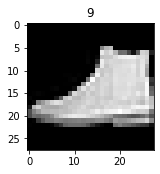

In [ ]:
### Examining the fashion MNIST training dataset ###

idx_train_img = 39064 #@param {type:"slider", min:0, max:59999, step:1}

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(MNIST.x_train[idx_train_img]), 'gray')
plt.title(np.squeeze(MNIST.y_train[idx_train_img])); plt.grid(False)

In [ ]:
# Training hyperparameters
roiSize = 28
epochs = 100
batch_size = 256
learning_rate = 1e-4
sample_interval = 50

# Create model
gan = GAN(shape=(roiSize,roiSize,1))

In [ ]:
# Train the model 
gen_loss, dis_loss= train_model(gan, epochs, batch_size=batch_size, learning_rate=learning_rate, sample_interval=sample_interval)


epoch 1/100
69888/70000 [============================>.] - ETA: 0s - gen_loss: -0.0021 - dis_loss: -1.3745e-04
epoch 2/100
69376/70000 [============================>.] - ETA: 0s - gen_loss: -0.0068 - dis_loss: -1.4964e-04
epoch 3/100
69632/70000 [============================>.] - ETA: 0s - gen_loss: -0.0068 - dis_loss: -5.6942e-05
epoch 4/100
69632/70000 [============================>.] - ETA: 0s - gen_loss: -0.0069 - dis_loss: -3.2237e-05
epoch 5/100
69632/70000 [============================>.] - ETA: 0s - gen_loss: -0.0065 - dis_loss: -3.1748e-05
epoch 6/100
69632/70000 [============================>.] - ETA: 0s - gen_loss: -0.0090 - dis_loss: -9.5705e-05
epoch 7/100
69376/70000 [============================>.] - ETA: 0s - gen_loss: -0.0096 - dis_loss: -7.6558e-05
epoch 8/100
69376/70000 [============================>.] - ETA: 0s - gen_loss: -0.0090 - dis_loss: -5.3757e-05
epoch 9/100
69632/70000 [============================>.] - ETA: 0s - gen_loss: -0.0087 - dis_loss: -5.5095e-05


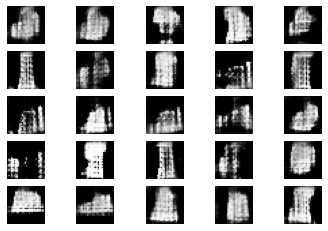

In [ ]:
sample_images(gan, 0, show=True)

In [ ]:
plt.plot(gen_loss, label="Generator loss")
plt.plot(dis_loss, label="Discriminator loss")
plt.ylabel("Loss")
plt.xlabel("iter")
plt.legend(loc="upper right")

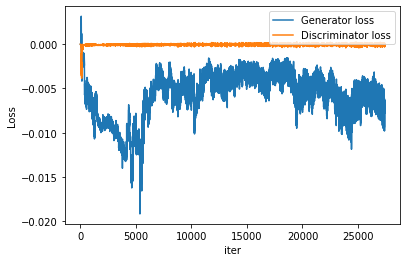

In [ ]:
plt.plot(gen_loss, label="Generator loss")
plt.plot(dis_loss, label="Discriminator loss")
plt.ylabel("Loss")
plt.xlabel("iter")
plt.legend(loc="upper right")